In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as subplots

# for model
from tqdm import tqdm
import tensorflow as tf
import keras
from keras import Model
import tensorflow
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array

import keras
import warnings
warnings.simplefilter("ignore")

import wandb
from wandb.sklearn import plot_precision_recall, plot_feature_importances, plot_summary_metrics
from wandb.sklearn import plot_class_proportions, plot_learning_curve, plot_roc

import cv2 as cv

import os
dataset_path = "/kaggle/input/e-commerce-products-images/"
image_path = "/kaggle/input/e-commerce-products-images/e-commerce/images/"
os.listdir(dataset_path)

['styles.csv', 'e-commerce']

### EDA

In [3]:
df = pd.read_csv(dataset_path + "styles.csv")

In [4]:
# Add columns
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)

In [5]:
df.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt,1855.jpg
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt,30805.jpg
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt,26960.jpg
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012.0,Casual,Puma Men Pack of 3 Socks,29114.jpg
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch,30039.jpg


In [6]:
df.describe()

,id,year
count,44441.000000,44440.000000
mean,29692.147049,2012.805873
std,17048.746205,2.126410
min,1163.000000,2007.000000
25%,14770.000000,2011.000000
50%,28608.000000,2012.000000
75%,44680.000000,2015.000000
max,60000.000000,2019.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44441 entries, 0 to 44440
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44441 non-null  int64  
 1   gender              44441 non-null  object 
 2   masterCategory      44441 non-null  object 
 3   subCategory         44441 non-null  object 
 4   articleType         44441 non-null  object 
 5   baseColour          44426 non-null  object 
 6   season              44420 non-null  object 
 7   year                44440 non-null  float64
 8   usage               44124 non-null  object 
 9   productDisplayName  44434 non-null  object 
 10  image               44441 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 3.7+ MB


In [8]:
import pandas as pd
import numpy as np

def analyze_product_categories(df):
    """
    Analyze and print unique categories, subcategories, and article types
    """
    print("Master Categories:")
    print(df['masterCategory'].unique())
    print("\nSub Categories:")
    print(df['subCategory'].unique())
    print("\nArticle Types:")
    print(df['articleType'].unique())
    return {
        'master_categories': df['masterCategory'].unique(),
        'sub_categories': df['subCategory'].unique(),
        'article_types': df['articleType'].unique()
    }

def create_product_attributes_mapping():
    """
    Create comprehensive mapping for all possible product attributes
    """
    attributes_mapping = {
        'Topwear': {
            'measurements': ['chest', 'shoulder', 'length', 'sleeve_length'],
            'style_attributes': ['neck_type', 'sleeve_type', 'pattern', 'fit_type'],
            'size_range': ['XS', 'S', 'M', 'L', 'XL', 'XXL'],
            'materials': ['Cotton', 'Polyester', 'Linen', 'Silk', 'Wool', 'Blend']
        },
        'Bottomwear': {
            'measurements': ['waist', 'length', 'hip', 'thigh', 'knee', 'ankle'],
            'style_attributes': ['rise_type', 'fit_type', 'pattern'],
            'size_range': list(range(28, 45, 2)),  # 28-44
            'materials': ['Cotton', 'Denim', 'Polyester', 'Linen', 'Wool', 'Blend']
        },
        'Footwear': {
            'measurements': ['foot_length', 'width'],
            'style_attributes': ['closure_type', 'heel_height', 'pattern'],
            'size_range': list(range(6, 13)),  # UK sizes 6-12
            'materials': ['Leather', 'Canvas', 'Synthetic', 'Mesh', 'Suede']
        },
        'Accessories': {
            'measurements': ['length', 'width', 'diameter'],
            'style_attributes': ['style_type', 'pattern'],
            'size_range': ['Free Size', 'S', 'M', 'L'],
            'materials': ['Metal', 'Leather', 'Fabric', 'Plastic', 'Glass']
        },
        'Dress': {
            'measurements': ['chest', 'waist', 'hip', 'length'],
            'style_attributes': ['dress_length', 'sleeve_type', 'pattern', 'fit_type'],
            'size_range': ['XS', 'S', 'M', 'L', 'XL', 'XXL'],
            'materials': ['Cotton', 'Polyester', 'Silk', 'Chiffon', 'Linen', 'Blend']
        },
        'Innerwear': {
            'measurements': ['chest', 'waist', 'hip'],
            'style_attributes': ['coverage_type', 'rise_type'],
            'size_range': ['XS', 'S', 'M', 'L', 'XL'],
            'materials': ['Cotton', 'Modal', 'Spandex', 'Nylon', 'Blend']
        },
        'Bags': {
            'measurements': ['length', 'width', 'height', 'strap_length'],
            'style_attributes': ['closure_type', 'pattern', 'number_of_compartments'],
            'size_range': ['Small', 'Medium', 'Large'],
            'materials': ['Leather', 'Canvas', 'Nylon', 'Polyester', 'Synthetic']
        },
        'Watches': {
            'measurements': ['dial_diameter', 'strap_length', 'strap_width'],
            'style_attributes': ['display_type', 'strap_type', 'water_resistance'],
            'size_range': ['Standard'],
            'materials': ['Metal', 'Leather', 'Rubber', 'Ceramic', 'Plastic']
        },
        'Jewellery': {
            'measurements': ['length', 'width', 'diameter'],
            'style_attributes': ['style_type', 'pattern', 'clasp_type'],
            'size_range': ['Free Size', 'Small', 'Medium', 'Large'],
            'materials': ['Gold', 'Silver', 'Platinum', 'Brass', 'Alloy']
        },
        'Eyewear': {
            'measurements': ['lens_width', 'bridge_width', 'temple_length'],
            'style_attributes': ['frame_shape', 'frame_type', 'lens_type'],
            'size_range': ['Standard', 'Narrow', 'Wide'],
            'materials': ['Metal', 'Plastic', 'Acetate', 'Composite']
        }
    }
    return attributes_mapping

def get_measurement_ranges():
    """
    Define measurement ranges for different attributes
    """
    return {
        'chest': list(range(32, 49, 2)),  # 32-48 inches
        'waist': list(range(28, 45, 2)),  # 28-44 inches
        'hip': list(range(34, 51, 2)),    # 34-50 inches
        'length': list(range(24, 43, 2)),  # 24-42 inches
        'shoulder': list(range(14, 21)),   # 14-20 inches
        'sleeve_length': list(range(22, 27)), # 22-26 inches
        'thigh': list(range(20, 31)),      # 20-30 inches
        'knee': list(range(14, 21)),       # 14-20 inches
        'ankle': list(range(10, 17)),      # 10-16 inches
        'foot_length': list(range(24, 31)), # 24-30 cm
        'dial_diameter': list(range(30, 47, 2)), # 30-46 mm
        'strap_length': list(range(18, 23)), # 18-22 cm
        'strap_width': list(range(16, 25, 2)), # 16-24 mm
        'lens_width': list(range(45, 61, 2)), # 45-60 mm
        'bridge_width': list(range(14, 21)), # 14-20 mm
        'temple_length': list(range(135, 151, 5)) # 135-150 mm
    }

def determine_product_attributes(row, attributes_mapping):
    """
    Determine product attributes based on category and subcategory
    """
    product_name = str(row['productDisplayName']).lower()
    master_cat = row['masterCategory']
    sub_cat = row['subCategory']
    
    # Get base category for mapping
    base_category = None
    if sub_cat in attributes_mapping:
        base_category = sub_cat
    elif master_cat in attributes_mapping:
        base_category = master_cat
    else:
        for cat in attributes_mapping:
            if cat.lower() in sub_cat.lower():
                base_category = cat
                break
    
    if not base_category:
        base_category = 'Accessories'  # default category
        
    # Get attributes from mapping
    attributes = attributes_mapping[base_category].copy()
    
    # Add specific product details
    attributes['product_specific'] = {
        'fit': determine_fit(product_name),
        'pattern': determine_pattern(product_name),
        'material': determine_material(product_name),
        'style': determine_style(product_name, master_cat)
    }
    
    return attributes

def determine_fit(product_name):
    """Determine fit type from product name"""
    fits = {
        'slim': ['slim', 'skinny', 'fitted'],
        'regular': ['regular', 'classic', 'straight'],
        'loose': ['loose', 'relaxed', 'oversized', 'baggy']
    }
    
    for fit_type, keywords in fits.items():
        if any(keyword in product_name for keyword in keywords):
            return fit_type
    return 'regular'  # default fit

def determine_pattern(product_name):
    """Determine pattern from product name"""
    patterns = {
        'solid': ['solid', 'plain'],
        'printed': ['print', 'printed', 'pattern', 'patterned'],
        'striped': ['stripe', 'striped'],
        'checked': ['check', 'checked', 'plaid'],
        'floral': ['floral', 'flower']
    }
    
    for pattern, keywords in patterns.items():
        if any(keyword in product_name for keyword in keywords):
            return pattern
    return 'solid'  # default pattern

def determine_material(product_name):
    """Determine material from product name"""
    materials = {
        'cotton': ['cotton'],
        'polyester': ['polyester', 'poly'],
        'wool': ['wool', 'woolen'],
        'leather': ['leather'],
        'denim': ['denim', 'jean'],
        'silk': ['silk'],
        'linen': ['linen'],
        'metal': ['metal', 'steel', 'gold', 'silver'],
        'synthetic': ['synthetic', 'nylon', 'rayon']
    }
    
    for material, keywords in materials.items():
        if any(keyword in product_name for keyword in keywords):
            return material
    return 'unknown'  # default material

def determine_style(product_name, category):
    """Determine style attributes"""
    styles = {
        'casual': ['casual', 'everyday', 'basic'],
        'formal': ['formal', 'business', 'office'],
        'party': ['party', 'festive', 'celebration'],
        'sports': ['sport', 'active', 'workout', 'athletic'],
        'ethnic': ['ethnic', 'traditional', 'cultural']
    }
    
    for style, keywords in styles.items():
        if any(keyword in product_name.lower() for keyword in keywords):
            return style
    return 'casual'  # default style

def enrich_product_data(df):
    """
    Main function to enrich product data with all possible attributes
    """
    # First analyze existing categories
    categories = analyze_product_categories(df)
    
    # Create attribute mappings
    attributes_mapping = create_product_attributes_mapping()
    measurement_ranges = get_measurement_ranges()
    
    # Add new columns
    df['product_attributes'] = df.apply(lambda row: determine_product_attributes(row, attributes_mapping), axis=1)
    
    # Extract specific attributes into separate columns
    df['fit_type'] = df.apply(lambda row: row['product_attributes']['product_specific']['fit'], axis=1)
    df['pattern'] = df.apply(lambda row: row['product_attributes']['product_specific']['pattern'], axis=1)
    df['material'] = df.apply(lambda row: row['product_attributes']['product_specific']['material'], axis=1)
    df['style'] = df.apply(lambda row: row['product_attributes']['product_specific']['style'], axis=1)
    
    # Add measurement ranges based on category
    df['measurement_ranges'] = df.apply(
        lambda row: {
            measure: measurement_ranges[measure] 
            for measure in row['product_attributes']['measurements']
            if measure in measurement_ranges
        }, 
        axis=1
    )
    
    return df

# Example usage:
# df = pd.read_csv('your_fashion_data.csv')
enriched_df = enrich_product_data(df)


Master Categories:
['Apparel' 'Accessories' 'Footwear' 'Personal Care' 'Free Items'
 'Sporting Goods' 'Home']

Sub Categories:
['Topwear' 'Bottomwear' 'Watches' 'Socks' 'Shoes' 'Belts' 'Flip Flops'
 'Bags' 'Innerwear' 'Sandal' 'Shoe Accessories' 'Fragrance' 'Jewellery'
 'Lips' 'Saree' 'Eyewear' 'Nails' 'Scarves' 'Dress'
 'Loungewear and Nightwear' 'Wallets' 'Apparel Set' 'Headwear' 'Mufflers'
 'Skin Care' 'Makeup' 'Free Gifts' 'Ties' 'Accessories' 'Skin'
 'Beauty Accessories' 'Water Bottle' 'Eyes' 'Bath and Body' 'Gloves'
 'Sports Accessories' 'Cufflinks' 'Sports Equipment' 'Stoles' 'Hair'
 'Perfumes' 'Home Furnishing' 'Umbrellas' 'Wristbands' 'Vouchers']

Article Types:
['Shirts' 'Jeans' 'Watches' 'Track Pants' 'Tshirts' 'Socks' 'Casual Shoes'
 'Belts' 'Flip Flops' 'Handbags' 'Tops' 'Bra' 'Sandals' 'Shoe Accessories'
 'Sweatshirts' 'Deodorant' 'Formal Shoes' 'Bracelet' 'Lipstick' 'Flats'
 'Kurtas' 'Waistcoat' 'Sports Shoes' 'Shorts' 'Briefs' 'Sarees'
 'Perfume and Body Mist' 'Heels' '

In [11]:
enriched_df['product_attributes'][0]

{'measurements': ['chest', 'shoulder', 'length', 'sleeve_length'],
 'style_attributes': ['neck_type', 'sleeve_type', 'pattern', 'fit_type'],
 'size_range': ['XS', 'S', 'M', 'L', 'XL', 'XXL'],
 'materials': ['Cotton', 'Polyester', 'Linen', 'Silk', 'Wool', 'Blend'],
 'product_specific': {'fit': 'regular',
  'pattern': 'checked',
  'material': 'unknown',
  'style': 'casual'}}

In [41]:
def perform_eda(df):
    """
    Perform Exploratory Data Analysis on fashion dataset
    """
    analysis_results = {}
    
    # Basic dataset info
    print("Dataset Shape:", df.shape)
    print("\nMissing Values:")
    print(df.isnull().sum())
    
    # Category Analysis
    analysis_results['category_distribution'] = {
        'master_category': df['masterCategory'].value_counts(),
        'sub_category': df['subCategory'].value_counts(),
        'article_type': df['articleType'].value_counts()
    }
    
    # Gender Distribution
    analysis_results['gender_distribution'] = df['gender'].value_counts()
    
    # Usage/Occasion Analysis
    analysis_results['usage_distribution'] = df['usage'].value_counts()
    
    # Season Analysis
    analysis_results['season_distribution'] = df['season'].value_counts()
    
    # Color Analysis
    analysis_results['color_distribution'] = df['baseColour'].value_counts()
    
    # Year Analysis
    analysis_results['year_distribution'] = df['year'].value_counts()
    
    # Visualizations
    plt.figure(figsize=(15, 10))
    
    # Master Category Distribution
    plt.subplot(2, 2, 1)
    sns.barplot(x=analysis_results['category_distribution']['master_category'].index,
                y=analysis_results['category_distribution']['master_category'].values)
    plt.title('Master Category Distribution')
    plt.xticks(rotation=45)
    
    # Gender Distribution
    plt.subplot(2, 2, 2)
    sns.barplot(x=analysis_results['gender_distribution'].index,
                y=analysis_results['gender_distribution'].values)
    plt.title('Gender Distribution')
    
    # Usage Distribution
    plt.subplot(2, 2, 3)
    sns.barplot(x=analysis_results['usage_distribution'].index,
                y=analysis_results['usage_distribution'].values)
    plt.title('Usage Distribution')
    plt.xticks(rotation=45)
    
    # Color Distribution (top 10)
    plt.subplot(2, 2, 4)
    color_dist = analysis_results['color_distribution'].head(10)
    sns.barplot(x=color_dist.index, y=color_dist.values)
    plt.title('Top 10 Colors')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return analysis_results



Dataset Shape: (44441, 17)

Missing Values:
id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
image                   0
product_attributes      0
fit_type                0
pattern                 0
material                0
style                   0
measurement_ranges      0
dtype: int64


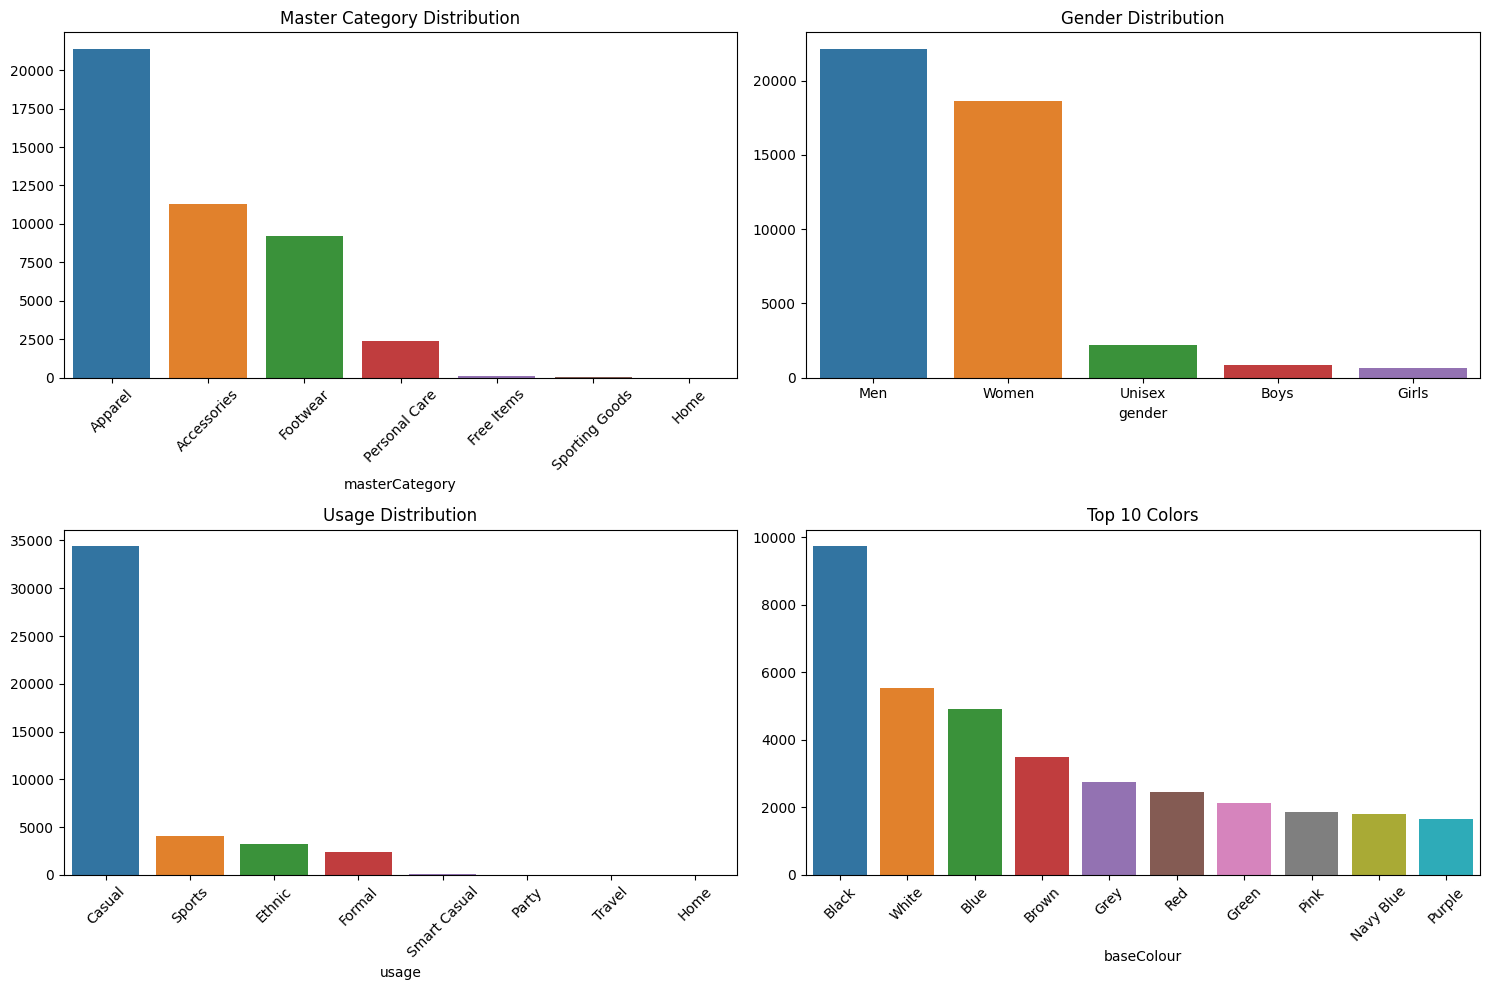

{'category_distribution': {'master_category': masterCategory
  Apparel           21395
  Accessories       11289
  Footwear           9222
  Personal Care      2404
  Free Items          105
  Sporting Goods       25
  Home                  1
  Name: count, dtype: int64,
  'sub_category': subCategory
  Topwear                     15401
  Shoes                        7344
  Bags                         3055
  Bottomwear                   2693
  Watches                      2542
  Innerwear                    1808
  Jewellery                    1080
  Eyewear                      1073
  Fragrance                    1012
  Sandal                        963
  Wallets                       933
  Flip Flops                    915
  Belts                         811
  Socks                         698
  Lips                          527
  Dress                         478
  Loungewear and Nightwear      470
  Saree                         427
  Nails                         329
  Makeup      

In [42]:
perform_eda(enriched_df)

In [12]:
enriched_df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image,product_attributes,fit_type,pattern,material,style,measurement_ranges
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg,"{'measurements': ['chest', 'shoulder', 'length...",regular,checked,unknown,casual,"{'chest': [32, 34, 36, 38, 40, 42, 44, 46, 48]..."
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg,"{'measurements': ['waist', 'length', 'hip', 't...",regular,solid,denim,party,"{'waist': [28, 30, 32, 34, 36, 38, 40, 42, 44]..."
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg,"{'measurements': ['dial_diameter', 'strap_leng...",regular,solid,metal,casual,"{'dial_diameter': [30, 32, 34, 36, 38, 40, 42,..."
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg,"{'measurements': ['waist', 'length', 'hip', 't...",regular,solid,unknown,casual,"{'waist': [28, 30, 32, 34, 36, 38, 40, 42, 44]..."
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg,"{'measurements': ['chest', 'shoulder', 'length...",regular,solid,unknown,casual,"{'chest': [32, 34, 36, 38, 40, 42, 44, 46, 48]..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44436,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe,17036.jpg,"{'measurements': ['foot_length', 'width'], 'st...",regular,solid,unknown,casual,"{'foot_length': [24, 25, 26, 27, 28, 29, 30]}"
44437,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop,6461.jpg,"{'measurements': ['foot_length', 'width'], 'st...",regular,solid,unknown,casual,"{'foot_length': [24, 25, 26, 27, 28, 29, 30]}"
44438,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt,18842.jpg,"{'measurements': ['chest', 'shoulder', 'length...",regular,solid,unknown,casual,"{'chest': [32, 34, 36, 38, 40, 42, 44, 46, 48]..."
44439,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume,46694.jpg,"{'measurements': ['length', 'width', 'diameter...",regular,solid,unknown,casual,"{'length': [24, 26, 28, 30, 32, 34, 36, 38, 40..."


In [13]:
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.metrics.pairwise import cosine_similarity

# class FashionRecommender:
#     def __init__(self):
#         self.df = None
#         self.feature_matrix = None
#         self.preprocessor = None
        
#     def fit(self, df):
#         """
#         Fit the recommender with the product dataset
#         """
#         self.df = df
        
#         # Define features for encoding
#         categorical_features = [
#             'gender',
#             'masterCategory',
#             'subCategory',
#             'articleType',
#             'season',
#             'usage',
#             'fit_type',
#             'style'
#         ]
        
#         # Create preprocessing pipeline
#         self.preprocessor = ColumnTransformer(
#             transformers=[
#                 ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
#             ]
#         )
        
#         # Create feature matrix
#         self.feature_matrix = self.preprocessor.fit_transform(self.df)
#         return self
    
#     def _check_measurements_compatibility(self, product_measurements, user_measurements):
#         """
#         Check if product measurements are compatible with user measurements
#         Returns a compatibility score between 0 and 1
#         """
#         if not isinstance(product_measurements, dict):
#             return 0
            
#         measurements = product_measurements.get('measurements', [])
#         ranges = product_measurements.get('measurement_ranges', {})
        
#         if not measurements or not ranges:
#             return 0
            
#         compatibility_scores = []
#         for measure, value in user_measurements.items():
#             if measure in measurements and measure in ranges:
#                 measure_range = ranges[measure]
#                 if isinstance(measure_range, list) and len(measure_range) > 0:
#                     # Find closest measurement in range
#                     closest = min(measure_range, key=lambda x: abs(x - value))
#                     # Calculate score based on how close the measurement is
#                     score = 1 - min(abs(closest - value) / value, 1)
#                     compatibility_scores.append(score)
                    
#         return np.mean(compatibility_scores) if compatibility_scores else 0
    
#     def get_recommendations(self, user_input):
#         """
#         Get product recommendations based on user input
        
#         Parameters:
#         user_input: dict containing:
#             - gender: str
#             - measurements: dict of measurements
#             - product_type: dict containing masterCategory, subCategory, articleType
#             - season: str
#             - occasion: str (maps to 'usage' in the dataset)
#         """
#         # Filter by basic criteria
#         mask = (
#             (self.df['gender'] == user_input['gender']) &
#             (self.df['masterCategory'] == user_input['product_type']['masterCategory']) &
#             (self.df['subCategory'] == user_input['product_type']['subCategory']) &
#             (self.df['articleType'] == user_input['product_type']['articleType']) &
#             (self.df['season'] == user_input['season']) &
#             (self.df['usage'] == user_input['occasion'])
#         )
        
#         filtered_df = self.df[mask]
#         if len(filtered_df) == 0:
#             return []
            
#         # Calculate measurement compatibility scores
#         compatibility_scores = filtered_df.apply(
#             lambda row: self._check_measurements_compatibility(
#                 eval(row['product_attributes']) if isinstance(row['product_attributes'], str) else row['product_attributes'],
#                 user_input['measurements']
#             ),
#             axis=1
#         )
        
#         # Get the indices of products with good measurement compatibility
#         compatible_indices = compatibility_scores[compatibility_scores > 0.7].index
        
#         if len(compatible_indices) == 0:
#             return []
            
#         # Get feature matrix for compatible products
#         compatible_features = self.feature_matrix[compatible_indices]
        
#         # Create user preference vector
#         user_preferences = {
#             'gender': user_input['gender'],
#             'masterCategory': user_input['product_type']['masterCategory'],
#             'subCategory': user_input['product_type']['subCategory'],
#             'articleType': user_input['product_type']['articleType'],
#             'season': user_input['season'],
#             'usage': user_input['occasion'],
#             'fit_type': user_input.get('fit_type', 'regular'),
#             'style': user_input.get('style', 'casual')
#         }
        
#         # Transform user preferences
#         user_vector = self.preprocessor.transform(pd.DataFrame([user_preferences]))
        
#         # Calculate similarity scores
#         similarity_scores = cosine_similarity(user_vector, compatible_features).flatten()
        
#         # Combine similarity with measurement compatibility
#         final_scores = similarity_scores * compatibility_scores[compatible_indices]
        
#         # Get top recommendations
#         top_indices = final_scores.argsort()[::-1][:5]
        
#         # Return recommendations with scores
#         recommendations = []
#         for idx in top_indices:
#             product = filtered_df.iloc[idx]
#             recommendations.append({
#                 'id': product['id'],
#                 'productDisplayName': product['productDisplayName'],
#                 'image': product['image'],
#                 'similarity_score': final_scores[idx],
#                 'measurements': product['product_attributes'],
#                 'style': product['style'],
#                 'fit_type': product['fit_type']
#             })
            
#         return recommendations

# # Example usage:
# def get_fashion_recommendations(df, user_input):
#     """
#     Get fashion recommendations based on user input
    
#     Example user_input:
#     {
#         'gender': 'Men',
#         'measurements': {
#             'chest': 40,
#             'shoulder': 17,
#             'length': 28
#         },
#         'product_type': {
#             'masterCategory': 'Apparel',
#             'subCategory': 'Topwear',
#             'articleType': 'Shirts'
#         },
#         'season': 'Fall',
#         'occasion': 'Casual',
#         'fit_type': 'regular',
#         'style': 'casual'
#     }
#     """
#     recommender = FashionRecommender()
#     recommender.fit(df)
#     return recommender.get_recommendations(user_input)

In [22]:
user_input={
        'gender': 'Men',
        'measurements': {
            'chest': 40,
            'shoulder': 17,
            'length': 28
       
    }}

In [ ]:
enriched

In [24]:
df=enriched_df

In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics.pairwise import cosine_similarity
import ast

class FashionRecommender:
    def __init__(self):
        self.df = None
        self.feature_matrix = None
        self.preprocessor = None
        
    def fit(self, df):
        """
        Fit the recommender with the product dataset
        """
        self.df = df.copy()
        
        # Convert string representations of dictionaries to actual dictionaries
        self.df['product_attributes'] = self.df['product_attributes'].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) else x
        )
        self.df['measurement_ranges'] = self.df['measurement_ranges'].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) else x
        )
        
        # Define features for encoding
        categorical_features = [
            'gender',
            'masterCategory',
            'subCategory',
            'articleType',
            'baseColour',
            'season',
            'usage',
            'fit_type',
            'pattern',
            'material',
            'style'
        ]
        
        # Create preprocessing pipeline
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
            ]
        )
        
        # Create feature matrix
        self.feature_matrix = self.preprocessor.fit_transform(self.df)
        return self
    
    def _check_measurements_compatibility(self, product_ranges, user_measurements):
        """
        Check if user measurements are compatible with product measurement ranges
        """
        if not product_ranges:
            return 0
            
        compatibility_scores = []
        for measure, value in user_measurements.items():
            if measure in product_ranges:
                measure_range = product_ranges[measure]
                if isinstance(measure_range, list) and len(measure_range) > 0:
                    # Check if measurement is within range
                    min_range = min(measure_range)
                    max_range = max(measure_range)
                    if min_range <= value <= max_range:
                        score = 1.0
                    else:
                        # Calculate distance from nearest range boundary
                        distance = min(abs(value - min_range), abs(value - max_range))
                        score = max(0, 1 - (distance / value))
                    compatibility_scores.append(score)
                    
        return np.mean(compatibility_scores) if compatibility_scores else 0
    
    def get_recommendations(self, user_input):
        """
        Get product recommendations based on user input
        """
        # Filter by basic criteria
        mask = (
            (self.df['gender'] == user_input['gender']) &
            (self.df['masterCategory'] == user_input['product_type']['masterCategory']) &
            (self.df['subCategory'] == user_input['product_type']['subCategory']) &
            (self.df['articleType'] == user_input['product_type']['articleType']) &
            (self.df['season'] == user_input['season']) &
            (self.df['usage'] == user_input['usage'])
        )
        
        # Add color filter if specified
        if 'baseColour' in user_input:
            mask &= (self.df['baseColour'] == user_input['baseColour'])
        
        filtered_df = self.df[mask].copy()
        if len(filtered_df) == 0:
            return []
            
        # Calculate measurement compatibility scores
        filtered_df['compatibility_score'] = filtered_df.apply(
            lambda row: self._check_measurements_compatibility(
                row['measurement_ranges'],
                user_input['measurements']
            ),
            axis=1
        )
        
        # Filter products with good measurement compatibility
        compatible_df = filtered_df[filtered_df['compatibility_score'] > 0.7]
        
        if len(compatible_df) == 0:
            return []
            
        # Get feature matrix for compatible products
        compatible_indices = compatible_df.index
        compatible_features = self.feature_matrix[compatible_df.index]
        
        # Create user preference vector
        user_preferences = {
            'gender': user_input['gender'],
            'masterCategory': user_input['product_type']['masterCategory'],
            'subCategory': user_input['product_type']['subCategory'],
            'articleType': user_input['product_type']['articleType'],
            'baseColour': user_input.get('baseColour', filtered_df.iloc[0]['baseColour']),
            'season': user_input['season'],
            'usage': user_input['usage'],
            'fit_type': user_input.get('fit_type', 'regular'),
            'pattern': user_input.get('pattern', 'solid'),
            'material': user_input.get('material', 'unknown'),
            'style': user_input.get('style', 'casual')
        }
        
        # Transform user preferences
        user_vector = self.preprocessor.transform(pd.DataFrame([user_preferences]))
        
        # Calculate similarity scores
        similarity_scores = cosine_similarity(user_vector, compatible_features).flatten()
        
        # Create DataFrame with scores for easy sorting
        results_df = pd.DataFrame({
            'similarity_score': similarity_scores,
            'compatibility_score': compatible_df['compatibility_score'].values
        }, index=compatible_df.index)
        
        # Calculate final scores and sort
        results_df['final_score'] = results_df['similarity_score'] * results_df['compatibility_score']
        top_indices = results_df.nlargest(5, 'final_score').index
        
        # Return recommendations
        recommendations = []
        for idx in top_indices:
            product = self.df.loc[idx]
            recommendations.append({
                'id': product['id'],
                'productDisplayName': product['productDisplayName'],
                'image': product['image'],
                'similarity_score': float(results_df.loc[idx, 'final_score']),
                'baseColour': product['baseColour'],
                'fit_type': product['fit_type'],
                'pattern': product['pattern'],
                'material': product['material'],
                'style': product['style'],
                'measurement_ranges': product['measurement_ranges']
            })
            
        return recommendations

# Example usage
def get_fashion_recommendations(df, user_input):
    """
    Get fashion recommendations
    
    Example user_input:
    {
        'gender': 'Men',
        'measurements': {
            'chest': 40,
            'shoulder': 17,
            'length': 28
        },
        'product_type': {
            'masterCategory': 'Apparel',
            'subCategory': 'Topwear',
            'articleType': 'Shirts'
        },
        'season': 'Fall',
        'usage': 'Casual',
        'baseColour': 'Navy Blue'  # Optional
    }
    """
    recommender = FashionRecommender()
    recommender.fit(df)
    return recommender.get_recommendations(user_input)

# Example test code:

user_input = {
    'gender': 'Men',
    'measurements': {
        'chest': 40,
        'shoulder': 17,
        'length': 28
    },
    'product_type': {
        'masterCategory': 'Apparel',
        'subCategory': 'Topwear',
        'articleType': 'Shirts'
    },
    'season': 'Fall',
    'usage': 'Casual',
    'baseColour': 'Navy Blue'
}

recommendations = get_fashion_recommendations(df, user_input)
for rec in recommendations:
    print(f"Product: {rec['productDisplayName']}")
    print(f"Color: {rec['baseColour']}")
    print(f"Similarity Score: {rec['similarity_score']:.2f}")
    print(f"Style: {rec['style']}")
    print(f"Pattern: {rec['pattern']}")
    print("---")


Product: Indigo Nation Men Club Satin Hot Stepper Navy Blue Shirt
Color: Navy Blue
Similarity Score: 1.00
Style: casual
Pattern: solid
---
Product: Scullers Men Scul Blue Shirts
Color: Navy Blue
Similarity Score: 1.00
Style: casual
Pattern: solid
---
Product: Flying Machine Men HS Blue Shirts
Color: Navy Blue
Similarity Score: 1.00
Style: casual
Pattern: solid
---
Product: United Colors Of Benetton Men Navy Blue Shirt
Color: Navy Blue
Similarity Score: 1.00
Style: casual
Pattern: solid
---
Product: Wrangler Men Aoston Navy Blue Shirt
Color: Navy Blue
Similarity Score: 1.00
Style: casual
Pattern: solid
---


In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics.pairwise import cosine_similarity
import ast

class FashionRecommender:
    def __init__(self):
        self.df = None
        self.feature_matrix = None
        self.preprocessor = None
        
    def fit(self, df):
        """
        Fit the recommender with the product dataset
        """
        self.df = df.copy()
        
        # Convert string representations of dictionaries to actual dictionaries
        self.df['product_attributes'] = self.df['product_attributes'].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) else x
        )
        self.df['measurement_ranges'] = self.df['measurement_ranges'].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) else x
        )
        
        # Define features for encoding
        categorical_features = [
            'gender',
            'masterCategory',
            'subCategory',
            'articleType',
            'baseColour',
            'season',
            'usage',
            'fit_type',
            'pattern',
            'material',
            'style'
        ]
        
        # Create preprocessing pipeline
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
            ]
        )
        
        # Create feature matrix
        self.feature_matrix = self.preprocessor.fit_transform(self.df)
        return self
    
    def _check_measurements_compatibility(self, product_ranges, user_measurements):
        """
        Check if user measurements are compatible with product measurement ranges
        Returns a weighted score even when measurements are missing
        """
        if not user_measurements or not product_ranges:
            return 0.6  # Base compatibility score when measurements are missing
            
        compatibility_scores = []
        for measure, value in user_measurements.items():
            if measure in product_ranges:
                measure_range = product_ranges[measure]
                if isinstance(measure_range, list) and len(measure_range) > 0:
                    min_range = min(measure_range)
                    max_range = max(measure_range)
                    if min_range <= value <= max_range:
                        score = 0.9  # High score for exact matches
                    else:
                        # Calculate distance-based score
                        distance = min(abs(value - min_range), abs(value - max_range))
                        score = max(0.3, 0.9 - (distance / value))
                    compatibility_scores.append(score)
                    
        return np.mean(compatibility_scores) if compatibility_scores else 0.6

    def _calculate_attribute_similarity(self, user_prefs, product):
        """
        Calculate similarity score based on matching attributes
        """
        similarity_score = 0.0
        weights = {
            'gender': 0.3,
            'masterCategory': 0.2,
            'subCategory': 0.15,
            'articleType': 0.1,
            'season': 0.1,
            'usage': 0.1,
            'baseColour': 0.05
        }
        
        total_weight = 0
        for attr, weight in weights.items():
            if attr in user_prefs:
                total_weight += weight
                if user_prefs[attr] == product[attr]:
                    similarity_score += weight
                    
        return similarity_score / total_weight if total_weight > 0 else 0.5

    def get_recommendations(self, user_input):
        """
        Get product recommendations with weighted scoring
        """
        # Initial filtering
        mask = pd.Series(True, index=self.df.index)
        
        # Apply basic filters
        if 'gender' in user_input:
            mask &= (self.df['gender'] == user_input['gender'])
            
        if 'product_type' in user_input:
            if 'masterCategory' in user_input['product_type']:
                mask &= (self.df['masterCategory'] == user_input['product_type']['masterCategory'])
            if 'subCategory' in user_input['product_type']:
                mask &= (self.df['subCategory'] == user_input['product_type']['subCategory'])
            if 'articleType' in user_input['product_type']:
                mask &= (self.df['articleType'] == user_input['product_type']['articleType'])
                
        if 'season' in user_input:
            mask &= (self.df['season'] == user_input['season'])
            
        if 'usage' in user_input:
            mask &= (self.df['usage'] == user_input['usage'])
            
        if 'baseColour' in user_input:
            mask &= (self.df['baseColour'] == user_input['baseColour'])
        
        filtered_df = self.df[mask].copy()
        if len(filtered_df) == 0:
            # Relax filters if no matches found
            mask = pd.Series(True, index=self.df.index)
            if 'gender' in user_input:
                mask &= (self.df['gender'] == user_input['gender'])
            if 'product_type' in user_input and 'masterCategory' in user_input['product_type']:
                mask &= (self.df['masterCategory'] == user_input['product_type']['masterCategory'])
            filtered_df = self.df[mask].copy()
            
        if len(filtered_df) == 0:
            return []
            
        # Calculate attribute similarity scores
        filtered_df['attribute_score'] = filtered_df.apply(
            lambda row: self._calculate_attribute_similarity({
                'gender': user_input.get('gender', row['gender']),
                'masterCategory': user_input.get('product_type', {}).get('masterCategory', row['masterCategory']),
                'subCategory': user_input.get('product_type', {}).get('subCategory', row['subCategory']),
                'articleType': user_input.get('product_type', {}).get('articleType', row['articleType']),
                'season': user_input.get('season', row['season']),
                'usage': user_input.get('usage', row['usage']),
                'baseColour': user_input.get('baseColour', row['baseColour'])
            }, row),
            axis=1
        )
        
        # Calculate measurement compatibility
        filtered_df['compatibility_score'] = filtered_df.apply(
            lambda row: self._check_measurements_compatibility(
                row['measurement_ranges'],
                user_input.get('measurements', {})
            ),
            axis=1
        )
        
        # Calculate style similarity
        filtered_df['style_score'] = filtered_df.apply(
            lambda row: 0.8 if user_input.get('style', row['style']) == row['style'] else 0.4,
            axis=1
        )
        
        # Calculate final weighted score
        filtered_df['final_score'] = (
            filtered_df['attribute_score'] * 0.4 +
            filtered_df['compatibility_score'] * 0.4 +
            filtered_df['style_score'] * 0.2
        )
        
        # Get top recommendations
        top_products = filtered_df.nlargest(5, 'final_score')
        
        # Prepare recommendations
        recommendations = []
        for _, product in top_products.iterrows():
            recommendations.append({
                'id': product['id'],
                'productDisplayName': product['productDisplayName'],
                'image': product['image'],
                'similarity_score': float(product['final_score']),
                'baseColour': product['baseColour'],
                'fit_type': product['fit_type'],
                'pattern': product['pattern'],
                'material': product['material'],
                'style': product['style'],
                'measurement_ranges': product['measurement_ranges']
            })
            
        return recommendations

def get_fashion_recommendations(df, user_input, print_scores=False):
    """
    Get fashion recommendations with detailed scoring
    
    Parameters:
    df : pandas DataFrame
        The product dataset
    user_input : dict
        Dictionary containing user preferences and measurements
        Example:
        {
            'gender': 'Men',
            'measurements': {
                'chest': 40,
                'shoulder': 17,
                'length': 28
            },
            'product_type': {
                'masterCategory': 'Apparel',
                'subCategory': 'Topwear',
                'articleType': 'Shirts'
            },
            'season': 'Fall',
            'usage': 'Casual',
            'baseColour': 'Navy Blue'  # Optional
        }
    print_scores : bool
        Whether to print detailed scoring breakdown
    
    Returns:
    list : List of recommended products with scores
    """
    recommender = FashionRecommender()
    recommender.fit(df)
    recommendations = recommender.get_recommendations(user_input)
    
    if print_scores:
        print("\nScoring Breakdown:")
        for rec in recommendations:
            print(f"\nProduct: {rec['productDisplayName']}")
            print(f"Total Score: {rec['similarity_score']:.2f}")
            print(f"Style: {rec['style']}")
            print(f"Color: {rec['baseColour']}")
            print("---")
    
    return recommendations

# Example usage:
if __name__ == "__main__":
    # Example with full input
    full_input = {
        'gender': 'Men',
        'measurements': {
            'chest': 40,
            'shoulder': 17,
            'length': 28
        },
        'product_type': {
            'masterCategory': 'Apparel',
            'subCategory': 'Topwear',
            'articleType': 'Shirts'
        },
        'season': 'Fall',
        'usage': 'Casual',
        'baseColour': 'Navy Blue'
    }
    
    # Example with minimal input
    minimal_input = {
        'gender': 'Men',
        'product_type': {
            'masterCategory': 'Apparel'
        }
    }
    
    # Example with partial input
    partial_input = {
        'gender': 'Men',
        'product_type': {
            'masterCategory': 'Apparel',
            'subCategory': 'Topwear'
        },
        'season': 'Fall'
    }
    
    # Get recommendations
    recommendations = get_fashion_recommendations(df, partial_input, print_scores=True)


Scoring Breakdown:

Product: Turtle Check Men Navy Blue Shirt
Total Score: 0.80
Style: casual
Color: Navy Blue
---

Product: Reid & Taylor Men Check Purple Shirts
Total Score: 0.80
Style: casual
Color: Purple
---

Product: ADIDAS Men Lfc Auth Hood Grey Sweatshirts
Total Score: 0.80
Style: casual
Color: Grey
---

Product: Fila Men's Round Neck Navy Blue T-shirt
Total Score: 0.80
Style: casual
Color: Navy Blue
---

Product: Scullers Men  Grey Waistcoat
Total Score: 0.80
Style: casual
Color: Grey
---


In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics.pairwise import cosine_similarity
import ast
import os

class FashionRecommender:
    def __init__(self, image_folder='images'):
        self.df = None
        self.feature_matrix = None
        self.preprocessor = None
        self.image_folder = image_folder
        
    def fit(self, df):
        """
        Fit the recommender with the product dataset
        """
        self.df = df.copy()
        
        # Convert string representations of dictionaries to actual dictionaries
        self.df['product_attributes'] = self.df['product_attributes'].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) else x
        )
        self.df['measurement_ranges'] = self.df['measurement_ranges'].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) else x
        )
        
        # Add full image path
        self.df['image_path'] = self.df['image'].apply(
            lambda x: os.path.join(self.image_folder, x) if pd.notnull(x) else None
        )
        
        # Define features for encoding
        categorical_features = [
            'gender',
            'masterCategory',
            'subCategory',
            'articleType',
            'baseColour',
            'season',
            'usage',
            'fit_type',
            'pattern',
            'material',
            'style'
        ]
        
        # Create preprocessing pipeline
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
            ]
        )
        
        # Create feature matrix
        self.feature_matrix = self.preprocessor.fit_transform(self.df)
        return self
    
    def _check_measurements_compatibility(self, product_ranges, user_measurements):
        """
        Check if user measurements are compatible with product measurement ranges
        """
        if not user_measurements or not product_ranges:
            return 0.6  # Base compatibility score when measurements are missing
            
        compatibility_scores = []
        for measure, value in user_measurements.items():
            if measure in product_ranges:
                measure_range = product_ranges[measure]
                if isinstance(measure_range, list) and len(measure_range) > 0:
                    min_range = min(measure_range)
                    max_range = max(measure_range)
                    if min_range <= value <= max_range:
                        score = 0.9  # High score for exact matches
                    else:
                        # Calculate distance-based score
                        distance = min(abs(value - min_range), abs(value - max_range))
                        score = max(0.3, 0.9 - (distance / value))
                    compatibility_scores.append(score)
                    
        return np.mean(compatibility_scores) if compatibility_scores else 0.6

    def _calculate_attribute_similarity(self, user_prefs, product):
        """
        Calculate similarity score based on matching attributes
        """
        similarity_score = 0.0
        weights = {
            'gender': 0.3,
            'masterCategory': 0.2,
            'subCategory': 0.15,
            'articleType': 0.1,
            'season': 0.1,
            'usage': 0.1,
            'baseColour': 0.05
        }
        
        total_weight = 0
        for attr, weight in weights.items():
            if attr in user_prefs:
                total_weight += weight
                if user_prefs[attr] == product[attr]:
                    similarity_score += weight
                    
        return similarity_score / total_weight if total_weight > 0 else 0.5

    def get_recommendations(self, user_input, num_recommendations=5):
        """
        Get product recommendations with weighted scoring
        
        Parameters:
        user_input : dict
            User preferences and measurements
        num_recommendations : int
            Number of recommendations to return (default: 5)
        """
        # Initial filtering
        mask = pd.Series(True, index=self.df.index)
        
        # Apply basic filters
        if 'gender' in user_input:
            mask &= (self.df['gender'] == user_input['gender'])
            
        if 'product_type' in user_input:
            if 'masterCategory' in user_input['product_type']:
                mask &= (self.df['masterCategory'] == user_input['product_type']['masterCategory'])
            if 'subCategory' in user_input['product_type']:
                mask &= (self.df['subCategory'] == user_input['product_type']['subCategory'])
            if 'articleType' in user_input['product_type']:
                mask &= (self.df['articleType'] == user_input['product_type']['articleType'])
                
        if 'season' in user_input:
            mask &= (self.df['season'] == user_input['season'])
            
        if 'usage' in user_input:
            mask &= (self.df['usage'] == user_input['usage'])
            
        if 'baseColour' in user_input:
            mask &= (self.df['baseColour'] == user_input['baseColour'])
        
        filtered_df = self.df[mask].copy()
        if len(filtered_df) == 0:
            # Relax filters if no matches found
            mask = pd.Series(True, index=self.df.index)
            if 'gender' in user_input:
                mask &= (self.df['gender'] == user_input['gender'])
            if 'product_type' in user_input and 'masterCategory' in user_input['product_type']:
                mask &= (self.df['masterCategory'] == user_input['product_type']['masterCategory'])
            filtered_df = self.df[mask].copy()
            
        if len(filtered_df) == 0:
            return []
            
        # Calculate attribute similarity scores
        filtered_df['attribute_score'] = filtered_df.apply(
            lambda row: self._calculate_attribute_similarity({
                'gender': user_input.get('gender', row['gender']),
                'masterCategory': user_input.get('product_type', {}).get('masterCategory', row['masterCategory']),
                'subCategory': user_input.get('product_type', {}).get('subCategory', row['subCategory']),
                'articleType': user_input.get('product_type', {}).get('articleType', row['articleType']),
                'season': user_input.get('season', row['season']),
                'usage': user_input.get('usage', row['usage']),
                'baseColour': user_input.get('baseColour', row['baseColour'])
            }, row),
            axis=1
        )
        
        # Calculate measurement compatibility
        filtered_df['compatibility_score'] = filtered_df.apply(
            lambda row: self._check_measurements_compatibility(
                row['measurement_ranges'],
                user_input.get('measurements', {})
            ),
            axis=1
        )
        
        # Calculate style similarity
        filtered_df['style_score'] = filtered_df.apply(
            lambda row: 0.8 if user_input.get('style', row['style']) == row['style'] else 0.4,
            axis=1
        )
        
        # Calculate final weighted score
        filtered_df['final_score'] = (
            filtered_df['attribute_score'] * 0.4 +
            filtered_df['compatibility_score'] * 0.4 +
            filtered_df['style_score'] * 0.2
        )
        
        # Get top recommendations
        num_recommendations = min(num_recommendations, len(filtered_df))
        top_products = filtered_df.nlargest(num_recommendations, 'final_score')
        
        # Prepare recommendations
        recommendations = []
        for _, product in top_products.iterrows():
            # Check if image file exists
            image_path = product['image_path']
            if image_path and os.path.exists(image_path):
                valid_image_path = image_path
            else:
                valid_image_path = None
                
            recommendations.append({
                'id': product['id'],
                'productDisplayName': product['productDisplayName'],
                'image': product['image'],
                'image_path': valid_image_path,
                'similarity_score': float(product['final_score']),
                'baseColour': product['baseColour'],
                'fit_type': product['fit_type'],
                'pattern': product['pattern'],
                'material': product['material'],
                'style': product['style'],
                'measurement_ranges': product['measurement_ranges'],
                'additional_details': {
                    'masterCategory': product['masterCategory'],
                    'subCategory': product['subCategory'],
                    'articleType': product['articleType'],
                    'season': product['season'],
                    'usage': product['usage']
                }
            })
            
        return recommendations

def get_fashion_recommendations(df, user_input, num_recommendations=5, image_folder='images', print_scores=False):
    """
    Get fashion recommendations with detailed scoring
    
    Parameters:
    df : pandas DataFrame
        The product dataset
    user_input : dict
        Dictionary containing user preferences and measurements
        Example:
        {
            'gender': 'Men',
            'measurements': {
                'chest': 40,
                'shoulder': 17,
                'length': 28
            },
            'product_type': {
                'masterCategory': 'Apparel',
                'subCategory': 'Topwear',
                'articleType': 'Shirts'
            },
            'season': 'Fall',
            'usage': 'Casual',
            'baseColour': 'Navy Blue'  # Optional
        }
    num_recommendations : int
        Number of recommendations to return (default: 5)
    image_folder : str
        Path to the folder containing product images
    print_scores : bool
        Whether to print detailed scoring breakdown
    
    Returns:
    list : List of recommended products with scores
    """
    recommender = FashionRecommender(image_folder=image_folder)
    recommender.fit(df)
    recommendations = recommender.get_recommendations(user_input, num_recommendations)
    
    if print_scores:
        print(f"\nTop {len(recommendations)} Recommendations:")
        for idx, rec in enumerate(recommendations, 1):
            print(f"\n{idx}. {'='*50}")
            print(f"Product: {rec['productDisplayName']}")
            print(f"ID: {rec['id']}")
            print(f"Image Path: {rec['image_path']}")
            print(f"Similarity Score: {rec['similarity_score']:.2f}")
            print(f"Color: {rec['baseColour']}")
            print(f"Style: {rec['style']}")
            print(f"Pattern: {rec['pattern']}")
            print(f"Fit Type: {rec['fit_type']}")
            print(f"Category: {rec['additional_details']['masterCategory']} > "
                  f"{rec['additional_details']['subCategory']} > "
                  f"{rec['additional_details']['articleType']}")
            print("="*50)
    
    return recommendations

# Example usage
if __name__ == "__main__":
    # Example with full input
    full_input = {
     
    'gender': 'Men',
    'product_type': {
        'masterCategory': 'Accessories',
        'subCategory': 'Bags',
    },
 
}
    
    
    # Get recommendations with custom number of recommendations
    recommendations = get_fashion_recommendations(
        df,
        full_input,
        num_recommendations=6,  # Specify number of recommendations
        image_folder='/kaggle/input/e-commerce-products-images/e-commerce/images',
        print_scores=True
    )


Top 6 Recommendations:

1. ==================================================
Product: ADIDAS Men Black Bag
ID: 31983
Image Path: /kaggle/input/e-commerce-products-images/e-commerce/images/31983.jpg
Similarity Score: 0.80
Color: Black
Style: casual
Pattern: solid
Fit Type: regular
Category: Accessories > Bags > Laptop Bag

2. ==================================================
Product: Fastrack Men Black Backpack
ID: 8376
Image Path: /kaggle/input/e-commerce-products-images/e-commerce/images/8376.jpg
Similarity Score: 0.80
Color: Black
Style: casual
Pattern: solid
Fit Type: regular
Category: Accessories > Bags > Backpacks

3. ==================================================
Product: Fastrack Men Black & Orange Backpack
ID: 8312
Image Path: /kaggle/input/e-commerce-products-images/e-commerce/images/8312.jpg
Similarity Score: 0.80
Color: Black
Style: casual
Pattern: solid
Fit Type: regular
Category: Accessories > Bags > Backpacks

4. ==================================================
P

In [43]:
enriched_df.to_csv('updated_data_fashion.csv')

In [50]:
from diffusers import StableDiffusionPipeline
import torch

pipeline = StableDiffusionPipeline.from_pretrained("MohamedRashad/diffusion_fashion")
pipeline.to("cpu")

prompt = "A photo of a dress, made in 2019, color is Red, Casual usage, Women's cloth, something for the summer season, on white background"
image = pipeline(prompt).images[0]
image.save("red_dress.png")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

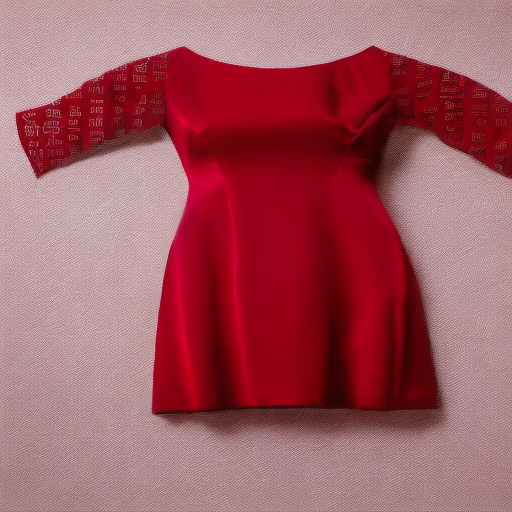

In [51]:
image

In [52]:
prompt = "A photo of a necklace, diamond on it, colur white and golden"
image = pipeline(prompt).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

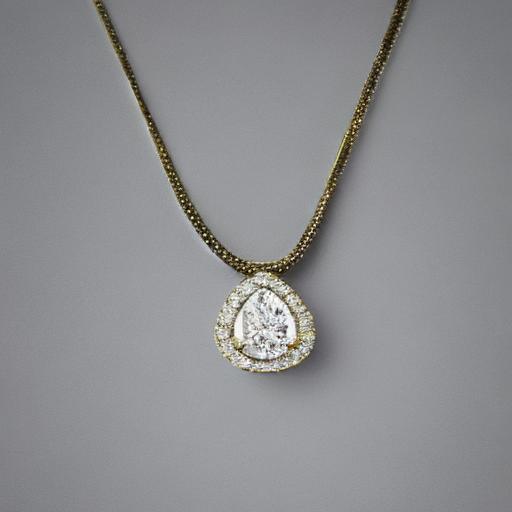

In [53]:
image

In [2]:
import pandas as pd

In [8]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'id', 'gender', 'masterCategory',
       'subCategory', 'articleType', 'baseColour', 'season', 'usage',
       'productDisplayName', 'image', 'product_attributes', 'fit_type',
       'pattern', 'material', 'style', 'measurement_ranges'],
      dtype='object')

In [3]:
df = pd.read_csv("updated_recommendation.csv")
# If `year` is not needed:
df.drop(columns=["year"], inplace=True, errors="ignore")

In [16]:
df.to_csv('updated_recommendation1.csv')

In [6]:
df = pd.read_csv('updated_recommendation1.csv')

In [13]:
df.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], errors="ignore", inplace=True , axis=1)


In [14]:
df.columns

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'usage', 'productDisplayName', 'image',
       'product_attributes', 'fit_type', 'pattern', 'material', 'style',
       'measurement_ranges'],
      dtype='object')

In [19]:
df = pd.read_csv('updated_recommendation1.csv')

In [18]:
df.dropna(inplace=True)

In [17]:
df.isnull().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
usage                 317
productDisplayName      7
image                   0
product_attributes      0
fit_type                0
pattern                 0
material                0
style                   0
measurement_ranges      0
dtype: int64